# Fully connected layer, 3 multitasks, reduced transformation
This notebook seeks to combine the finding that having two fully connected layers to each of three multitask outcomes as well as reducing the randomresizedcrop in the input transformation. This is of course in the hope, that since they each performed well, then perhaps they do even better together. 

This notebook uses all three label types; visual attributes, violence and protest labels

In [18]:
import sys
sys.path.append("../../venv/lib/python3.6/site-packages/")
sys.path.append("../")

In [19]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import backend as Kbackend
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
import h5py
import itertools
from lib import transforms

### Loading up the data

In [20]:
pc = cursor.ProtestCursor()
# imgs = pc.getLabelledImagesAndNonProtest(source="UCLA", label_source="UCLA original")
imgs = pc.getLabelledImages(source="UCLA")
len(imgs)


11646

### Preprocessing

In [21]:
cols = ["name", "label"]
tag_cols = ["sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
imgs = imgs[cols + tag_cols]
# indx_non_violence = imgs['label'].isnull()
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.217776,True,False,False,False,False,True,True,False,True,False
94c4c6443cbc9c14,test-00002.jpg,0.127544,True,False,False,False,False,False,False,False,False,False
0b2cf29e92aa294f,test-00010.jpg,0.192229,True,False,False,False,False,True,True,False,False,False
160335f46456562e,test-00013.jpg,0.112424,True,False,False,False,False,False,False,False,False,False
6a22e2626c464360,test-00020.jpg,0.128325,True,False,False,False,False,True,False,False,False,False
7864656be2a2260b,test-00028.jpg,0.174908,True,False,False,False,False,True,True,False,False,False
a494c469ac8e8ec4,test-00029.jpg,0.197768,True,False,False,False,False,False,False,True,False,False
94d0f7b39ebce000,test-00030.jpg,0.112204,True,False,False,False,True,True,False,False,False,False
195acace4e4b65c4,test-00037.jpg,0.194717,True,False,False,False,True,True,True,False,False,False


In [22]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
# imgs.loc[indx_non_violence, "violence"] = -1

df = imgs
df

,name,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.506455,True,False,False,False,False,True,True,False,True,False
94c4c6443cbc9c14,test-00002.jpg,0.296613,True,False,False,False,False,False,False,False,False,False
0b2cf29e92aa294f,test-00010.jpg,0.447045,True,False,False,False,False,True,True,False,False,False
160335f46456562e,test-00013.jpg,0.261452,True,False,False,False,False,False,False,False,False,False
6a22e2626c464360,test-00020.jpg,0.298431,True,False,False,False,False,True,False,False,False,False
7864656be2a2260b,test-00028.jpg,0.406762,True,False,False,False,False,True,True,False,False,False
a494c469ac8e8ec4,test-00029.jpg,0.459925,True,False,False,False,False,False,False,True,False,False
94d0f7b39ebce000,test-00030.jpg,0.260939,True,False,False,False,True,True,False,False,False,False
195acace4e4b65c4,test-00037.jpg,0.452831,True,False,False,False,True,True,True,False,False,False


### Divide the data

In [23]:
n_folds = 5
seed = 300

In [24]:
# k_folds = au.getKSplitsStratified(df, n_folds, "protest", seed )
k_folds = au.getKSplits(df, n_folds, seed )
# for i in k_folds:
#     print("kfold has ", len(i[i["protest"] == True]), "protest images and ", len(i[i["protest"] == False]), "non protest images")

In [25]:
# print first fold
k_folds[0]

,name,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,
b75c99623a6bcad9,train-17160.jpg,0.424870,True,False,False,False,False,True,True,False,False,False
7f3cac0ed29624aa,train-16341.jpg,0.523459,False,False,False,True,False,False,False,False,False,False
b639999581091513,train-12964.jpg,0.234170,True,False,False,False,False,True,False,False,False,False
397850f6e4caca2e,train-07695.jpg,0.285241,False,False,False,False,False,True,False,True,False,False
ecbdf0e4ed5d3d6d,train-27461.jpg,0.353837,True,False,False,False,False,False,False,True,False,False
597831a1a769cad2,test-00300.jpg,0.385766,True,False,False,False,False,True,False,False,False,False
80a6c69207060b09,train-19425.jpg,0.589804,False,False,True,False,False,False,False,False,False,False
de7a72664cc43624,test-07460.jpg,0.759600,False,False,True,False,False,False,False,False,False,False
478120a040cdb434,train-08125.jpg,0.359988,False,False,False,False,False,True,False,True,False,False


In [26]:
validation_df = k_folds[0].copy()
test_df = k_folds[1].copy()
train_df = k_folds[2].copy().append(k_folds[3].copy()).append(k_folds[4].copy())
print("train set has ", len(train_df) , " images. validation has ", len(validation_df), " images and test has ", len(test_df))

train set has  6988  images. validation has  2329  images and test has  2329


In [27]:
batch_size = 32

In [28]:
dummy_test_generator = au.ResizeSequence(
    train_df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['violence', tag_cols],
    transforms = [
        lambda img: transforms.randomResizedCrop(img, min_percent=70),
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


protest has shape (32,)  violence has shape (32, 10)


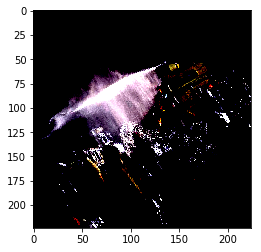

In [29]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape)

In [30]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 100; patience = 10

In [31]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

'momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300'

In [32]:
# COMMENT THIS OUT FOR RUN WITH THE WHOLE DATA SET
# size_sample = 10
# validation_df = validation_df[:size_sample]
# test_df = test_df[:size_sample]
# train_df = train_df[:size_sample]
# epochs = 1
# batch_size = 2
# patience = 0

In [34]:
train_generator = au.ResizeSequence(
    train_df,
    batch_size, 
    targets = ['violence', tag_cols],
    transforms = [
        lambda img: transforms.randomResizedCrop(img, min_percent=70),
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ]
)
validation_generator = au.ResizeSequence(
    validation_df,
    batch_size, 
    targets = ['violence', tag_cols],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

test_generator = au.ResizeSequence(
test_df,
batch_size, 
targets = ['violence', tag_cols],
transforms = [
    transforms.resize,
    transforms.centerCrop,
    transforms.normalizeMinMax,
    transforms.normalizeStandardScore
]
)



# Modeling start
Kbackend.clear_session()

img_input = Klayers.Input(shape=(224,224,3), name='img_input')

resnet_model = Kapplications.ResNet50(include_top=False, weights = 'imagenet') (img_input)

flatten = Klayers.Flatten()(resnet_model)

fully_connected_violence = Klayers.Dense(1000, activation='relu')(flatten)
dropout_violence = Klayers.Dropout(.5)(fully_connected_violence)
violence_out = Klayers.Dense(1, activation='sigmoid', name='violence_out')(dropout_violence)


# fully_connected_protest = Klayers.Dense(1000, activation= 'relu') (flatten)
# dropout_protest = Klayers.Dropout(.5) (fully_connected_protest)
# protest_out = Klayers.Dense(1, activation='sigmoid', name='protest_out')(dropout_protest)

fully_connected_visuals = Klayers.Dense(1000, activation= 'relu') (flatten)
dropout_visuals = Klayers.Dropout(.5)(fully_connected_visuals)
visual_out = Klayers.Dense(10, activation='sigmoid', name='visual_out')(dropout_visuals)

model = Kmodels.Model(inputs= img_input, outputs=[violence_out, visual_out])

optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
model.compile(
    optimizer=optimizer,
    loss={
#         'protest_out': Klosses.binary_crossentropy,
        'violence_out': Klosses.mean_squared_error,
        'visual_out': Klosses.binary_crossentropy, 
    },
    loss_weights={
#         'protest_out': 1., 
        'violence_out': 10,
        'visual_out': 5,
    }
)
model.summary()

try:
    __file__ # Apparently, this is not defined in the notebook,
         # but it will be when we start running on the server
         # (So when things gets real)
except NameError:
    __file__ = "test"


name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name)
csv_results = "models_preds/%s.csv" % name
model_checkout_path = "models/%s.hdf5" % name
csv_logger_path = "logs/%s.csv" % name
tensor_board_folder = os.path.join("logs", name)

if not os.path.exists(tensor_board_folder):
    os.makedirs(tensor_board_folder)

if not os.path.exists(tensor_board_folder):
    os.makedirs("logs")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models_preds")

print("Writing model to: \t%s" % model_checkout_path)
print("Writing log to: \t%s\n" % csv_logger_path)



# callbacks
change_lr = Kcallbacks.LearningRateScheduler(
    au.lrUpdateUCLA, 
    verbose = True
)

checkpoint = Kcallbacks.ModelCheckpoint(
    model_checkout_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
)

earlystop = Kcallbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=patience,
    verbose=1, 
    mode='auto'
)

tensor_board = Kcallbacks.TensorBoard(
    log_dir=tensor_board_folder,
     histogram_freq=0,
     batch_size=32, 
     write_graph=True,
     write_grads=False, 
     write_images=False, 
     embeddings_freq=0,
     embeddings_layer_names=None,
     embeddings_metadata=None
)

csv_logger = Kcallbacks.CSVLogger(
    csv_logger_path, 
    separator=',', 
    append=False
)

history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger, earlystop]
)


# Preds

#load the weights from the best model
model.load_weights(model_checkout_path)

preds = model.predict_generator(test_generator, verbose = 1)
# preds_protest = preds[0][:len(test_df)] # avoid getting more than the needed
preds_violence = preds[0][:len(test_df)] 
preds_visuals = preds[1][:len(test_df)] 
print("violence shape is ", preds_violence.shape, "visual shape is ", preds_visuals.shape)
# Creates a panda data frame with the results

test_fold_results = test_df.copy()
# test_fold_results["pred_protest"] = preds_protest
test_fold_results["pred_violence"] = preds_violence
for i, tc in enumerate(tag_cols):
    pred_tc = "pred_%s" % tc
    test_fold_results[pred_tc] = preds_visuals[:,i]

print("saving results")
test_fold_results.to_csv(csv_results)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                multiple             23587712    img_input[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1000)         2049000     flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (D